# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 164

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 200

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
import copy
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms.v2 import (
    RandomHorizontalFlip,
    Compose,
    RandomCrop,
    RandomShortestSize,
    AutoAugment,
    Normalize,
    CenterCrop,
    ToImage,
    ToDtype,
)
from torchvision.transforms.autoaugment import AutoAugmentPolicy
import matplotlib.pyplot as plt
import numpy as np


tmp.train_data.transform = Compose(
    [
        Compose([ToImage(), ToDtype(torch.float32, scale=True)]),
        Normalize(
            mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True
        ),
        RandomCrop(
            size=(32, 32),
            padding=[4, 4, 4, 4],
            pad_if_needed=False,
            fill=0,
            padding_mode="constant",
        ),
        RandomHorizontalFlip(p=0.5),
    ]
)

In [6]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)


train.transforms = Compose(
      Compose(
        ToImage()
        ToDtype(scale=True)
  )
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
test.transforms = Compose(
      ToImage()
      ToDtype(scale=True)
) 128


# Define ResNet

## Model Confirm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [9]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [10]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [11]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [12]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [13]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [14]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [15]:
optimizer.param_groups[0]["lr"]

0.1

In [16]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [17]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])


for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/164] :


1 Train: 100%|███████| 391/391 [00:16<00:00, 23.54it/s]

Train Loss: 2.3262 | Train Acc: 14.81%


Test  Loss: 2.1915 | Test Acc: 18.50%
updated best eval loss : 2.1914695682404917
--------------------------------------------------
[Epoch 2/164] :


2 Train: 100%|███████| 391/391 [00:12<00:00, 30.95it/s]


Train Loss: 1.5980 | Train Acc: 40.70%
Test  Loss: 1.8476 | Test Acc: 37.28%
updated best eval loss : 1.8476054879683483
--------------------------------------------------
[Epoch 3/164] :


3 Train: 100%|███████| 391/391 [00:12<00:00, 30.83it/s]


Train Loss: 1.1405 | Train Acc: 59.27%
Test  Loss: 1.0715 | Test Acc: 61.47%
updated best eval loss : 1.0714761516715907
--------------------------------------------------
[Epoch 4/164] :


4 Train: 100%|███████| 391/391 [00:12<00:00, 32.35it/s]


Train Loss: 0.9072 | Train Acc: 67.85%
Test  Loss: 1.4656 | Test Acc: 53.26%
--------------------------------------------------
[Epoch 5/164] :


5 Train: 100%|███████| 391/391 [00:12<00:00, 30.63it/s]


Train Loss: 0.7602 | Train Acc: 73.31%
Test  Loss: 1.0961 | Test Acc: 62.82%
--------------------------------------------------
[Epoch 6/164] :


6 Train: 100%|███████| 391/391 [00:09<00:00, 41.39it/s]


Train Loss: 0.6710 | Train Acc: 76.79%
Test  Loss: 1.0044 | Test Acc: 66.35%
updated best eval loss : 1.0044329166412354
--------------------------------------------------
[Epoch 7/164] :


7 Train: 100%|███████| 391/391 [00:08<00:00, 45.27it/s]


Train Loss: 0.6078 | Train Acc: 78.98%
Test  Loss: 0.7726 | Test Acc: 74.05%
updated best eval loss : 0.7725851294360583
--------------------------------------------------
[Epoch 8/164] :


8 Train: 100%|███████| 391/391 [00:08<00:00, 45.88it/s]


Train Loss: 0.5666 | Train Acc: 80.27%
Test  Loss: 0.9547 | Test Acc: 68.44%
--------------------------------------------------
[Epoch 9/164] :


9 Train: 100%|███████| 391/391 [00:08<00:00, 45.76it/s]


Train Loss: 0.5269 | Train Acc: 81.96%
Test  Loss: 1.2506 | Test Acc: 61.33%
--------------------------------------------------
[Epoch 10/164] :


10 Train: 100%|██████| 391/391 [00:09<00:00, 43.11it/s]


Train Loss: 0.5004 | Train Acc: 82.83%
Test  Loss: 0.8177 | Test Acc: 73.43%
--------------------------------------------------
[Epoch 11/164] :


11 Train: 100%|██████| 391/391 [00:08<00:00, 45.71it/s]


Train Loss: 0.4776 | Train Acc: 83.45%
Test  Loss: 0.7156 | Test Acc: 75.90%
updated best eval loss : 0.7155703113803381
--------------------------------------------------
[Epoch 12/164] :


12 Train: 100%|██████| 391/391 [00:08<00:00, 46.17it/s]


Train Loss: 0.4558 | Train Acc: 84.32%
Test  Loss: 0.7135 | Test Acc: 75.85%
updated best eval loss : 0.7134771716745594
--------------------------------------------------
[Epoch 13/164] :


13 Train: 100%|██████| 391/391 [00:08<00:00, 45.23it/s]


Train Loss: 0.4387 | Train Acc: 84.73%
Test  Loss: 0.6887 | Test Acc: 77.81%
updated best eval loss : 0.6886533766607695
--------------------------------------------------
[Epoch 14/164] :


14 Train: 100%|██████| 391/391 [00:08<00:00, 46.29it/s]


Train Loss: 0.4215 | Train Acc: 85.24%
Test  Loss: 0.8357 | Test Acc: 73.78%
--------------------------------------------------
[Epoch 15/164] :


15 Train: 100%|██████| 391/391 [00:08<00:00, 45.48it/s]


Train Loss: 0.4075 | Train Acc: 85.74%
Test  Loss: 0.7216 | Test Acc: 76.80%
--------------------------------------------------
[Epoch 16/164] :


16 Train: 100%|██████| 391/391 [00:08<00:00, 45.59it/s]


Train Loss: 0.3977 | Train Acc: 86.46%
Test  Loss: 0.7458 | Test Acc: 74.94%
--------------------------------------------------
[Epoch 17/164] :


17 Train: 100%|██████| 391/391 [00:08<00:00, 45.24it/s]


Train Loss: 0.3848 | Train Acc: 86.62%
Test  Loss: 0.8035 | Test Acc: 74.69%
--------------------------------------------------
[Epoch 18/164] :


18 Train: 100%|██████| 391/391 [00:08<00:00, 46.14it/s]


Train Loss: 0.3716 | Train Acc: 86.98%
Test  Loss: 0.8286 | Test Acc: 75.89%
--------------------------------------------------
[Epoch 19/164] :


19 Train: 100%|██████| 391/391 [00:08<00:00, 47.38it/s]


Train Loss: 0.3626 | Train Acc: 87.50%
Test  Loss: 1.0380 | Test Acc: 69.78%
--------------------------------------------------
[Epoch 20/164] :


20 Train: 100%|██████| 391/391 [00:08<00:00, 45.61it/s]


Train Loss: 0.3546 | Train Acc: 87.68%
Test  Loss: 0.7623 | Test Acc: 75.21%
--------------------------------------------------
[Epoch 21/164] :


21 Train: 100%|██████| 391/391 [00:08<00:00, 46.03it/s]


Train Loss: 0.3389 | Train Acc: 88.28%
Test  Loss: 0.7321 | Test Acc: 77.44%
--------------------------------------------------
[Epoch 22/164] :


22 Train: 100%|██████| 391/391 [00:08<00:00, 46.01it/s]


Train Loss: 0.3352 | Train Acc: 88.30%
Test  Loss: 0.7371 | Test Acc: 76.34%
--------------------------------------------------
[Epoch 23/164] :


23 Train: 100%|██████| 391/391 [00:08<00:00, 45.71it/s]


Train Loss: 0.3276 | Train Acc: 88.64%
Test  Loss: 1.3513 | Test Acc: 65.51%
--------------------------------------------------
[Epoch 24/164] :


24 Train: 100%|██████| 391/391 [00:08<00:00, 44.97it/s]


Train Loss: 0.3255 | Train Acc: 88.61%
Test  Loss: 0.5392 | Test Acc: 81.74%
updated best eval loss : 0.5391767677627032
--------------------------------------------------
[Epoch 25/164] :


25 Train: 100%|██████| 391/391 [00:08<00:00, 48.23it/s]


Train Loss: 0.3117 | Train Acc: 89.14%
Test  Loss: 0.5091 | Test Acc: 82.73%
updated best eval loss : 0.5091154654569263
--------------------------------------------------
[Epoch 26/164] :


26 Train: 100%|██████| 391/391 [00:08<00:00, 45.16it/s]


Train Loss: 0.3108 | Train Acc: 89.34%
Test  Loss: 0.6661 | Test Acc: 78.58%
--------------------------------------------------
[Epoch 27/164] :


27 Train: 100%|██████| 391/391 [00:09<00:00, 42.65it/s]


Train Loss: 0.3050 | Train Acc: 89.36%
Test  Loss: 0.9378 | Test Acc: 73.88%
--------------------------------------------------
[Epoch 28/164] :


28 Train: 100%|██████| 391/391 [00:08<00:00, 44.52it/s]


Train Loss: 0.3004 | Train Acc: 89.54%
Test  Loss: 0.7803 | Test Acc: 75.59%
--------------------------------------------------
[Epoch 29/164] :


29 Train: 100%|██████| 391/391 [00:08<00:00, 45.10it/s]


Train Loss: 0.2926 | Train Acc: 89.81%
Test  Loss: 1.2678 | Test Acc: 67.27%
--------------------------------------------------
[Epoch 30/164] :


30 Train: 100%|██████| 391/391 [00:08<00:00, 45.90it/s]


Train Loss: 0.2920 | Train Acc: 89.84%
Test  Loss: 0.5818 | Test Acc: 81.12%
--------------------------------------------------
[Epoch 31/164] :


31 Train: 100%|██████| 391/391 [00:08<00:00, 45.74it/s]


Train Loss: 0.2853 | Train Acc: 89.96%
Test  Loss: 0.5537 | Test Acc: 82.58%
--------------------------------------------------
[Epoch 32/164] :


32 Train: 100%|██████| 391/391 [00:08<00:00, 47.16it/s]


Train Loss: 0.2780 | Train Acc: 90.24%
Test  Loss: 0.7654 | Test Acc: 77.96%
--------------------------------------------------
[Epoch 33/164] :


33 Train: 100%|██████| 391/391 [00:08<00:00, 45.62it/s]


Train Loss: 0.2798 | Train Acc: 90.26%
Test  Loss: 0.8798 | Test Acc: 74.62%
--------------------------------------------------
[Epoch 34/164] :


34 Train: 100%|██████| 391/391 [00:09<00:00, 42.50it/s]


Train Loss: 0.2740 | Train Acc: 90.38%
Test  Loss: 0.7295 | Test Acc: 77.44%
--------------------------------------------------
[Epoch 35/164] :


35 Train: 100%|██████| 391/391 [00:08<00:00, 45.86it/s]


Train Loss: 0.2741 | Train Acc: 90.29%
Test  Loss: 0.6910 | Test Acc: 78.75%
--------------------------------------------------
[Epoch 36/164] :


36 Train: 100%|██████| 391/391 [00:08<00:00, 43.69it/s]


Train Loss: 0.2646 | Train Acc: 90.73%
Test  Loss: 0.9388 | Test Acc: 73.54%
--------------------------------------------------
[Epoch 37/164] :


37 Train: 100%|██████| 391/391 [00:08<00:00, 43.96it/s]


Train Loss: 0.2638 | Train Acc: 90.76%
Test  Loss: 0.7958 | Test Acc: 77.37%
--------------------------------------------------
[Epoch 38/164] :


38 Train: 100%|██████| 391/391 [00:08<00:00, 47.18it/s]


Train Loss: 0.2597 | Train Acc: 91.00%
Test  Loss: 0.5876 | Test Acc: 81.20%
--------------------------------------------------
[Epoch 39/164] :


39 Train: 100%|██████| 391/391 [00:08<00:00, 45.30it/s]


Train Loss: 0.2644 | Train Acc: 90.71%
Test  Loss: 0.8147 | Test Acc: 74.60%
--------------------------------------------------
[Epoch 40/164] :


40 Train: 100%|██████| 391/391 [00:08<00:00, 45.23it/s]


Train Loss: 0.2576 | Train Acc: 91.04%
Test  Loss: 0.7970 | Test Acc: 76.24%
--------------------------------------------------
[Epoch 41/164] :


41 Train: 100%|██████| 391/391 [00:08<00:00, 46.22it/s]


Train Loss: 0.2514 | Train Acc: 91.14%
Test  Loss: 0.8840 | Test Acc: 73.81%
--------------------------------------------------
[Epoch 42/164] :


42 Train: 100%|██████| 391/391 [00:08<00:00, 45.98it/s]


Train Loss: 0.2454 | Train Acc: 91.40%
Test  Loss: 0.6650 | Test Acc: 79.90%
--------------------------------------------------
[Epoch 43/164] :


43 Train: 100%|██████| 391/391 [00:08<00:00, 45.66it/s]


Train Loss: 0.2477 | Train Acc: 91.29%
Test  Loss: 1.2006 | Test Acc: 68.55%
--------------------------------------------------
[Epoch 44/164] :


44 Train: 100%|██████| 391/391 [00:08<00:00, 45.78it/s]


Train Loss: 0.2442 | Train Acc: 91.44%
Test  Loss: 0.6575 | Test Acc: 78.33%
--------------------------------------------------
[Epoch 45/164] :


45 Train: 100%|██████| 391/391 [00:08<00:00, 46.95it/s]


Train Loss: 0.2432 | Train Acc: 91.53%
Test  Loss: 0.9262 | Test Acc: 73.06%
--------------------------------------------------
[Epoch 46/164] :


46 Train: 100%|██████| 391/391 [00:08<00:00, 44.94it/s]


Train Loss: 0.2401 | Train Acc: 91.66%
Test  Loss: 0.7177 | Test Acc: 78.85%
--------------------------------------------------
[Epoch 47/164] :


47 Train: 100%|██████| 391/391 [00:08<00:00, 45.32it/s]


Train Loss: 0.2419 | Train Acc: 91.48%
Test  Loss: 0.6186 | Test Acc: 80.99%
--------------------------------------------------
[Epoch 48/164] :


48 Train: 100%|██████| 391/391 [00:08<00:00, 43.92it/s]


Train Loss: 0.2396 | Train Acc: 91.53%
Test  Loss: 0.8062 | Test Acc: 75.15%
--------------------------------------------------
[Epoch 49/164] :


49 Train: 100%|██████| 391/391 [00:08<00:00, 45.41it/s]


Train Loss: 0.2278 | Train Acc: 92.07%
Test  Loss: 0.6726 | Test Acc: 80.19%
--------------------------------------------------
[Epoch 50/164] :


50 Train: 100%|██████| 391/391 [00:08<00:00, 44.61it/s]


Train Loss: 0.2373 | Train Acc: 91.73%
Test  Loss: 0.7535 | Test Acc: 76.82%
--------------------------------------------------
[Epoch 51/164] :


51 Train: 100%|██████| 391/391 [00:08<00:00, 46.61it/s]


Train Loss: 0.2295 | Train Acc: 92.01%
Test  Loss: 0.9187 | Test Acc: 73.92%
--------------------------------------------------
[Epoch 52/164] :


52 Train: 100%|██████| 391/391 [00:08<00:00, 46.25it/s]


Train Loss: 0.2275 | Train Acc: 91.95%
Test  Loss: 0.6740 | Test Acc: 80.17%
--------------------------------------------------
[Epoch 53/164] :


53 Train: 100%|██████| 391/391 [00:08<00:00, 45.93it/s]


Train Loss: 0.2298 | Train Acc: 91.93%
Test  Loss: 0.5392 | Test Acc: 83.03%
--------------------------------------------------
[Epoch 54/164] :


54 Train: 100%|██████| 391/391 [00:09<00:00, 42.08it/s]


Train Loss: 0.2246 | Train Acc: 92.01%
Test  Loss: 1.0017 | Test Acc: 72.61%
--------------------------------------------------
[Epoch 55/164] :


55 Train: 100%|██████| 391/391 [00:08<00:00, 45.52it/s]


Train Loss: 0.2244 | Train Acc: 92.09%
Test  Loss: 0.6544 | Test Acc: 80.86%
--------------------------------------------------
[Epoch 56/164] :


56 Train: 100%|██████| 391/391 [00:08<00:00, 44.94it/s]


Train Loss: 0.2238 | Train Acc: 92.19%
Test  Loss: 0.6723 | Test Acc: 79.32%
--------------------------------------------------
[Epoch 57/164] :


57 Train: 100%|██████| 391/391 [00:08<00:00, 45.43it/s]


Train Loss: 0.2182 | Train Acc: 92.32%
Test  Loss: 0.5744 | Test Acc: 81.87%
--------------------------------------------------
[Epoch 58/164] :


58 Train: 100%|██████| 391/391 [00:08<00:00, 45.95it/s]


Train Loss: 0.2215 | Train Acc: 92.22%
Test  Loss: 0.4894 | Test Acc: 84.40%
updated best eval loss : 0.4894446817379964
--------------------------------------------------
[Epoch 59/164] :


59 Train: 100%|██████| 391/391 [00:08<00:00, 45.21it/s]


Train Loss: 0.2178 | Train Acc: 92.41%
Test  Loss: 0.4937 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 60/164] :


60 Train: 100%|██████| 391/391 [00:08<00:00, 44.62it/s]


Train Loss: 0.2160 | Train Acc: 92.46%
Test  Loss: 0.5510 | Test Acc: 82.78%
--------------------------------------------------
[Epoch 61/164] :


61 Train: 100%|██████| 391/391 [00:08<00:00, 45.93it/s]


Train Loss: 0.2112 | Train Acc: 92.65%
Test  Loss: 0.5739 | Test Acc: 82.08%
--------------------------------------------------
[Epoch 62/164] :


62 Train: 100%|██████| 391/391 [00:08<00:00, 46.09it/s]


Train Loss: 0.2143 | Train Acc: 92.44%
Test  Loss: 0.4940 | Test Acc: 83.83%
--------------------------------------------------
[Epoch 63/164] :


63 Train: 100%|██████| 391/391 [00:08<00:00, 46.22it/s]


Train Loss: 0.2086 | Train Acc: 92.63%
Test  Loss: 0.7063 | Test Acc: 79.08%
--------------------------------------------------
[Epoch 64/164] :


64 Train: 100%|██████| 391/391 [00:08<00:00, 46.25it/s]


Train Loss: 0.2114 | Train Acc: 92.49%
Test  Loss: 0.6141 | Test Acc: 80.97%
--------------------------------------------------
[Epoch 65/164] :


65 Train: 100%|██████| 391/391 [00:08<00:00, 46.38it/s]


Train Loss: 0.2085 | Train Acc: 92.58%
Test  Loss: 0.6624 | Test Acc: 80.90%
--------------------------------------------------
[Epoch 66/164] :


66 Train: 100%|██████| 391/391 [00:08<00:00, 45.48it/s]


Train Loss: 0.2074 | Train Acc: 92.65%
Test  Loss: 0.5325 | Test Acc: 83.44%
--------------------------------------------------
[Epoch 67/164] :


67 Train: 100%|██████| 391/391 [00:08<00:00, 45.04it/s]


Train Loss: 0.2123 | Train Acc: 92.57%
Test  Loss: 0.5791 | Test Acc: 82.91%
--------------------------------------------------
[Epoch 68/164] :


68 Train: 100%|██████| 391/391 [00:08<00:00, 45.60it/s]


Train Loss: 0.2089 | Train Acc: 92.58%
Test  Loss: 0.6370 | Test Acc: 81.24%
--------------------------------------------------
[Epoch 69/164] :


69 Train: 100%|██████| 391/391 [00:08<00:00, 45.67it/s]


Train Loss: 0.2035 | Train Acc: 92.78%
Test  Loss: 0.5111 | Test Acc: 83.85%
--------------------------------------------------
[Epoch 70/164] :


70 Train: 100%|██████| 391/391 [00:08<00:00, 44.74it/s]


Train Loss: 0.2054 | Train Acc: 92.73%
Test  Loss: 0.5456 | Test Acc: 83.24%
--------------------------------------------------
[Epoch 71/164] :


71 Train: 100%|██████| 391/391 [00:08<00:00, 47.70it/s]


Train Loss: 0.2032 | Train Acc: 93.00%
Test  Loss: 0.7794 | Test Acc: 77.55%
--------------------------------------------------
[Epoch 72/164] :


72 Train: 100%|██████| 391/391 [00:08<00:00, 46.07it/s]


Train Loss: 0.1967 | Train Acc: 92.99%
Test  Loss: 0.6029 | Test Acc: 82.12%
--------------------------------------------------
[Epoch 73/164] :


73 Train: 100%|██████| 391/391 [00:08<00:00, 45.65it/s]


Train Loss: 0.2025 | Train Acc: 92.91%
Test  Loss: 1.0336 | Test Acc: 75.25%
--------------------------------------------------
[Epoch 74/164] :


74 Train: 100%|██████| 391/391 [00:08<00:00, 45.52it/s]


Train Loss: 0.2079 | Train Acc: 92.59%
Test  Loss: 0.9635 | Test Acc: 75.11%
--------------------------------------------------
[Epoch 75/164] :


75 Train: 100%|██████| 391/391 [00:08<00:00, 45.46it/s]


Train Loss: 0.2002 | Train Acc: 93.06%
Test  Loss: 0.5992 | Test Acc: 82.00%
--------------------------------------------------
[Epoch 76/164] :


76 Train: 100%|██████| 391/391 [00:08<00:00, 46.19it/s]


Train Loss: 0.1986 | Train Acc: 93.03%
Test  Loss: 0.7029 | Test Acc: 80.95%
--------------------------------------------------
[Epoch 77/164] :


77 Train: 100%|██████| 391/391 [00:08<00:00, 45.35it/s]


Train Loss: 0.1976 | Train Acc: 93.02%
Test  Loss: 0.5912 | Test Acc: 82.71%
--------------------------------------------------
[Epoch 78/164] :


78 Train: 100%|██████| 391/391 [00:08<00:00, 46.03it/s]


Train Loss: 0.2000 | Train Acc: 92.92%
Test  Loss: 0.4847 | Test Acc: 84.70%
updated best eval loss : 0.4846729211792161
--------------------------------------------------
[Epoch 79/164] :


79 Train: 100%|██████| 391/391 [00:08<00:00, 44.92it/s]


Train Loss: 0.1983 | Train Acc: 93.07%
Test  Loss: 0.8030 | Test Acc: 77.15%
--------------------------------------------------
[Epoch 80/164] :


80 Train: 100%|██████| 391/391 [00:09<00:00, 42.49it/s]


Train Loss: 0.1992 | Train Acc: 92.99%
Test  Loss: 0.5580 | Test Acc: 83.78%
--------------------------------------------------
[Epoch 81/164] :


81 Train: 100%|██████| 391/391 [00:08<00:00, 44.35it/s]


Train Loss: 0.2019 | Train Acc: 92.92%
Test  Loss: 0.5869 | Test Acc: 82.25%
--------------------------------------------------
[Epoch 82/164] :


82 Train: 100%|██████| 391/391 [00:08<00:00, 45.90it/s]


Train Loss: 0.1948 | Train Acc: 93.19%
Test  Loss: 0.6683 | Test Acc: 80.13%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 83/164] :


83 Train: 100%|██████| 391/391 [00:08<00:00, 44.86it/s]


Train Loss: 0.1140 | Train Acc: 96.12%
Test  Loss: 0.4154 | Test Acc: 87.35%
updated best eval loss : 0.41541592632950863
--------------------------------------------------
[Epoch 84/164] :


84 Train: 100%|██████| 391/391 [00:08<00:00, 47.00it/s]


Train Loss: 0.0881 | Train Acc: 97.04%
Test  Loss: 0.4301 | Test Acc: 86.92%
--------------------------------------------------
[Epoch 85/164] :


85 Train: 100%|██████| 391/391 [00:08<00:00, 44.96it/s]


Train Loss: 0.0740 | Train Acc: 97.58%
Test  Loss: 0.4176 | Test Acc: 87.75%
--------------------------------------------------
[Epoch 86/164] :


86 Train: 100%|██████| 391/391 [00:08<00:00, 45.09it/s]


Train Loss: 0.0679 | Train Acc: 97.73%
Test  Loss: 0.4497 | Test Acc: 86.92%
--------------------------------------------------
[Epoch 87/164] :


87 Train: 100%|██████| 391/391 [00:08<00:00, 44.61it/s]


Train Loss: 0.0654 | Train Acc: 97.85%
Test  Loss: 0.4926 | Test Acc: 86.51%
--------------------------------------------------
[Epoch 88/164] :


88 Train: 100%|██████| 391/391 [00:08<00:00, 45.08it/s]


Train Loss: 0.0588 | Train Acc: 98.09%
Test  Loss: 0.4628 | Test Acc: 87.37%
--------------------------------------------------
[Epoch 89/164] :


89 Train: 100%|██████| 391/391 [00:08<00:00, 44.06it/s]


Train Loss: 0.0571 | Train Acc: 98.09%
Test  Loss: 0.4464 | Test Acc: 87.71%
--------------------------------------------------
[Epoch 90/164] :


90 Train: 100%|██████| 391/391 [00:08<00:00, 45.72it/s]


Train Loss: 0.0536 | Train Acc: 98.23%
Test  Loss: 0.4401 | Test Acc: 88.01%
--------------------------------------------------
[Epoch 91/164] :


91 Train: 100%|██████| 391/391 [00:08<00:00, 46.47it/s]


Train Loss: 0.0504 | Train Acc: 98.36%
Test  Loss: 0.5104 | Test Acc: 86.59%
--------------------------------------------------
[Epoch 92/164] :


92 Train: 100%|██████| 391/391 [00:08<00:00, 46.27it/s]


Train Loss: 0.0485 | Train Acc: 98.44%
Test  Loss: 0.5305 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 93/164] :


93 Train: 100%|██████| 391/391 [00:08<00:00, 45.99it/s]


Train Loss: 0.0475 | Train Acc: 98.40%
Test  Loss: 0.4519 | Test Acc: 87.85%
--------------------------------------------------
[Epoch 94/164] :


94 Train: 100%|██████| 391/391 [00:08<00:00, 44.79it/s]


Train Loss: 0.0433 | Train Acc: 98.55%
Test  Loss: 0.4881 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 95/164] :


95 Train: 100%|██████| 391/391 [00:08<00:00, 45.09it/s]


Train Loss: 0.0415 | Train Acc: 98.69%
Test  Loss: 0.4758 | Test Acc: 87.63%
--------------------------------------------------
[Epoch 96/164] :


96 Train: 100%|██████| 391/391 [00:08<00:00, 46.01it/s]


Train Loss: 0.0408 | Train Acc: 98.62%
Test  Loss: 0.4900 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 97/164] :


97 Train: 100%|██████| 391/391 [00:08<00:00, 47.19it/s]


Train Loss: 0.0399 | Train Acc: 98.69%
Test  Loss: 0.4547 | Test Acc: 88.15%
--------------------------------------------------
[Epoch 98/164] :


98 Train: 100%|██████| 391/391 [00:08<00:00, 45.38it/s]


Train Loss: 0.0369 | Train Acc: 98.89%
Test  Loss: 0.5314 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 99/164] :


99 Train: 100%|██████| 391/391 [00:08<00:00, 45.57it/s]


Train Loss: 0.0352 | Train Acc: 98.90%
Test  Loss: 0.5117 | Test Acc: 87.52%
--------------------------------------------------
[Epoch 100/164] :


100 Train: 100%|█████| 391/391 [00:08<00:00, 45.22it/s]


Train Loss: 0.0342 | Train Acc: 98.89%
Test  Loss: 0.5274 | Test Acc: 86.84%
--------------------------------------------------
[Epoch 101/164] :


101 Train: 100%|█████| 391/391 [00:08<00:00, 45.07it/s]


Train Loss: 0.0344 | Train Acc: 98.87%
Test  Loss: 0.5569 | Test Acc: 86.84%
--------------------------------------------------
[Epoch 102/164] :


102 Train: 100%|█████| 391/391 [00:08<00:00, 45.74it/s]


Train Loss: 0.0336 | Train Acc: 98.85%
Test  Loss: 0.5917 | Test Acc: 86.44%
--------------------------------------------------
[Epoch 103/164] :


103 Train: 100%|█████| 391/391 [00:08<00:00, 45.67it/s]


Train Loss: 0.0297 | Train Acc: 99.03%
Test  Loss: 0.5573 | Test Acc: 87.29%
--------------------------------------------------
[Epoch 104/164] :


104 Train: 100%|█████| 391/391 [00:08<00:00, 45.51it/s]


Train Loss: 0.0310 | Train Acc: 99.01%
Test  Loss: 0.5420 | Test Acc: 87.26%
--------------------------------------------------
[Epoch 105/164] :


105 Train: 100%|█████| 391/391 [00:08<00:00, 46.13it/s]


Train Loss: 0.0289 | Train Acc: 99.09%
Test  Loss: 0.5516 | Test Acc: 87.40%
--------------------------------------------------
[Epoch 106/164] :


106 Train: 100%|█████| 391/391 [00:08<00:00, 45.29it/s]


Train Loss: 0.0306 | Train Acc: 99.00%
Test  Loss: 0.5279 | Test Acc: 87.71%
--------------------------------------------------
[Epoch 107/164] :


107 Train: 100%|█████| 391/391 [00:08<00:00, 46.04it/s]


Train Loss: 0.0281 | Train Acc: 99.10%
Test  Loss: 0.5721 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 108/164] :


108 Train: 100%|█████| 391/391 [00:08<00:00, 45.53it/s]


Train Loss: 0.0294 | Train Acc: 99.08%
Test  Loss: 0.5308 | Test Acc: 87.76%
--------------------------------------------------
[Epoch 109/164] :


109 Train: 100%|█████| 391/391 [00:08<00:00, 44.70it/s]


Train Loss: 0.0262 | Train Acc: 99.17%
Test  Loss: 0.5898 | Test Acc: 86.95%
--------------------------------------------------
[Epoch 110/164] :


110 Train: 100%|█████| 391/391 [00:08<00:00, 45.88it/s]


Train Loss: 0.0247 | Train Acc: 99.22%
Test  Loss: 0.5499 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 111/164] :


111 Train: 100%|█████| 391/391 [00:08<00:00, 46.57it/s]


Train Loss: 0.0252 | Train Acc: 99.21%
Test  Loss: 0.5472 | Test Acc: 87.83%
--------------------------------------------------
[Epoch 112/164] :


112 Train: 100%|█████| 391/391 [00:08<00:00, 45.97it/s]


Train Loss: 0.0250 | Train Acc: 99.18%
Test  Loss: 0.6073 | Test Acc: 86.36%
--------------------------------------------------
[Epoch 113/164] :


113 Train: 100%|█████| 391/391 [00:08<00:00, 46.11it/s]


Train Loss: 0.0240 | Train Acc: 99.22%
Test  Loss: 0.5268 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 114/164] :


114 Train: 100%|█████| 391/391 [00:08<00:00, 45.67it/s]


Train Loss: 0.0235 | Train Acc: 99.31%
Test  Loss: 0.5599 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 115/164] :


115 Train: 100%|█████| 391/391 [00:08<00:00, 45.66it/s]


Train Loss: 0.0229 | Train Acc: 99.28%
Test  Loss: 0.5909 | Test Acc: 86.90%
--------------------------------------------------
[Epoch 116/164] :


116 Train: 100%|█████| 391/391 [00:08<00:00, 45.65it/s]


Train Loss: 0.0209 | Train Acc: 99.37%
Test  Loss: 0.6195 | Test Acc: 86.66%
--------------------------------------------------
[Epoch 117/164] :


117 Train: 100%|█████| 391/391 [00:08<00:00, 47.70it/s]


Train Loss: 0.0213 | Train Acc: 99.33%
Test  Loss: 0.5808 | Test Acc: 87.28%
--------------------------------------------------
[Epoch 118/164] :


118 Train: 100%|█████| 391/391 [00:08<00:00, 45.32it/s]


Train Loss: 0.0228 | Train Acc: 99.27%
Test  Loss: 0.5802 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 119/164] :


119 Train: 100%|█████| 391/391 [00:08<00:00, 45.06it/s]


Train Loss: 0.0213 | Train Acc: 99.35%
Test  Loss: 0.6308 | Test Acc: 86.23%
--------------------------------------------------
[Epoch 120/164] :


120 Train: 100%|█████| 391/391 [00:08<00:00, 44.83it/s]


Train Loss: 0.0206 | Train Acc: 99.39%
Test  Loss: 0.5954 | Test Acc: 86.90%
--------------------------------------------------
[Epoch 121/164] :


121 Train: 100%|█████| 391/391 [00:08<00:00, 44.92it/s]


Train Loss: 0.0200 | Train Acc: 99.40%
Test  Loss: 0.5999 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 122/164] :


122 Train: 100%|█████| 391/391 [00:08<00:00, 45.36it/s]


Train Loss: 0.0194 | Train Acc: 99.42%
Test  Loss: 0.6213 | Test Acc: 86.95%
--------------------------------------------------
[Epoch 123/164] :


123 Train: 100%|█████| 391/391 [00:09<00:00, 42.58it/s]


Train Loss: 0.0191 | Train Acc: 99.40%
Test  Loss: 0.6413 | Test Acc: 86.79%
Learning Rate has changed : Now is 0.0010000000000000002
--------------------------------------------------
[Epoch 124/164] :


124 Train: 100%|█████| 391/391 [00:08<00:00, 45.30it/s]


Train Loss: 0.0183 | Train Acc: 99.46%
Test  Loss: 0.5737 | Test Acc: 87.52%
--------------------------------------------------
[Epoch 125/164] :


125 Train: 100%|█████| 391/391 [00:08<00:00, 46.10it/s]


Train Loss: 0.0163 | Train Acc: 99.49%
Test  Loss: 0.5862 | Test Acc: 87.39%
--------------------------------------------------
[Epoch 126/164] :


126 Train: 100%|█████| 391/391 [00:08<00:00, 45.13it/s]


Train Loss: 0.0157 | Train Acc: 99.58%
Test  Loss: 0.5625 | Test Acc: 87.62%
--------------------------------------------------
[Epoch 127/164] :


127 Train: 100%|█████| 391/391 [00:08<00:00, 44.00it/s]


Train Loss: 0.0144 | Train Acc: 99.60%
Test  Loss: 0.5863 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 128/164] :


128 Train: 100%|█████| 391/391 [00:08<00:00, 44.80it/s]


Train Loss: 0.0148 | Train Acc: 99.60%
Test  Loss: 0.5958 | Test Acc: 87.41%
--------------------------------------------------
[Epoch 129/164] :


129 Train: 100%|█████| 391/391 [00:08<00:00, 44.55it/s]


Train Loss: 0.0142 | Train Acc: 99.58%
Test  Loss: 0.5902 | Test Acc: 87.38%
--------------------------------------------------
[Epoch 130/164] :


130 Train: 100%|█████| 391/391 [00:08<00:00, 46.51it/s]


Train Loss: 0.0141 | Train Acc: 99.61%
Test  Loss: 0.5613 | Test Acc: 87.76%
--------------------------------------------------
[Epoch 131/164] :


131 Train: 100%|█████| 391/391 [00:08<00:00, 45.55it/s]


Train Loss: 0.0150 | Train Acc: 99.55%
Test  Loss: 0.5820 | Test Acc: 87.47%
--------------------------------------------------
[Epoch 132/164] :


132 Train: 100%|█████| 391/391 [00:08<00:00, 45.06it/s]


Train Loss: 0.0139 | Train Acc: 99.63%
Test  Loss: 0.5853 | Test Acc: 87.37%
--------------------------------------------------
[Epoch 133/164] :


133 Train: 100%|█████| 391/391 [00:08<00:00, 45.47it/s]


Train Loss: 0.0142 | Train Acc: 99.60%
Test  Loss: 0.5748 | Test Acc: 87.58%
--------------------------------------------------
[Epoch 134/164] :


134 Train: 100%|█████| 391/391 [00:08<00:00, 46.00it/s]


Train Loss: 0.0140 | Train Acc: 99.60%
Test  Loss: 0.5758 | Test Acc: 87.45%
--------------------------------------------------
[Epoch 135/164] :


135 Train: 100%|█████| 391/391 [00:08<00:00, 45.94it/s]


Train Loss: 0.0136 | Train Acc: 99.64%
Test  Loss: 0.6118 | Test Acc: 87.27%
--------------------------------------------------
[Epoch 136/164] :


136 Train: 100%|█████| 391/391 [00:08<00:00, 46.15it/s]


Train Loss: 0.0138 | Train Acc: 99.62%
Test  Loss: 0.5756 | Test Acc: 87.47%
--------------------------------------------------
[Epoch 137/164] :


137 Train: 100%|█████| 391/391 [00:08<00:00, 48.02it/s]


Train Loss: 0.0124 | Train Acc: 99.68%
Test  Loss: 0.5946 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 138/164] :


138 Train: 100%|█████| 391/391 [00:08<00:00, 45.76it/s]


Train Loss: 0.0128 | Train Acc: 99.64%
Test  Loss: 0.6240 | Test Acc: 86.95%
--------------------------------------------------
[Epoch 139/164] :


139 Train: 100%|█████| 391/391 [00:08<00:00, 45.45it/s]


Train Loss: 0.0132 | Train Acc: 99.62%
Test  Loss: 0.5867 | Test Acc: 87.65%
--------------------------------------------------
[Epoch 140/164] :


140 Train: 100%|█████| 391/391 [00:08<00:00, 45.59it/s]


Train Loss: 0.0132 | Train Acc: 99.66%
Test  Loss: 0.5807 | Test Acc: 87.62%
--------------------------------------------------
[Epoch 141/164] :


141 Train: 100%|█████| 391/391 [00:08<00:00, 45.80it/s]


Train Loss: 0.0124 | Train Acc: 99.67%
Test  Loss: 0.5799 | Test Acc: 87.56%
--------------------------------------------------
[Epoch 142/164] :


142 Train: 100%|█████| 391/391 [00:08<00:00, 44.58it/s]


Train Loss: 0.0127 | Train Acc: 99.65%
Test  Loss: 0.5936 | Test Acc: 87.43%
--------------------------------------------------
[Epoch 143/164] :


143 Train: 100%|█████| 391/391 [00:09<00:00, 43.43it/s]


Train Loss: 0.0119 | Train Acc: 99.69%
Test  Loss: 0.5889 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 144/164] :


144 Train: 100%|█████| 391/391 [00:08<00:00, 45.30it/s]


Train Loss: 0.0118 | Train Acc: 99.67%
Test  Loss: 0.5769 | Test Acc: 87.69%
--------------------------------------------------
[Epoch 145/164] :


145 Train: 100%|█████| 391/391 [00:08<00:00, 46.50it/s]


Train Loss: 0.0122 | Train Acc: 99.69%
Test  Loss: 0.5954 | Test Acc: 87.35%
--------------------------------------------------
[Epoch 146/164] :


146 Train: 100%|█████| 391/391 [00:08<00:00, 45.96it/s]


Train Loss: 0.0127 | Train Acc: 99.65%
Test  Loss: 0.6084 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 147/164] :


147 Train: 100%|█████| 391/391 [00:09<00:00, 43.44it/s]


Train Loss: 0.0130 | Train Acc: 99.65%
Test  Loss: 0.5821 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 148/164] :


148 Train: 100%|█████| 391/391 [00:08<00:00, 45.19it/s]


Train Loss: 0.0123 | Train Acc: 99.69%
Test  Loss: 0.5764 | Test Acc: 87.72%
--------------------------------------------------
[Epoch 149/164] :


149 Train: 100%|█████| 391/391 [00:08<00:00, 45.47it/s]


Train Loss: 0.0117 | Train Acc: 99.69%
Test  Loss: 0.6159 | Test Acc: 87.20%
--------------------------------------------------
[Epoch 150/164] :


150 Train: 100%|█████| 391/391 [00:09<00:00, 43.36it/s]


Train Loss: 0.0126 | Train Acc: 99.68%
Test  Loss: 0.5820 | Test Acc: 87.58%
--------------------------------------------------
[Epoch 151/164] :


151 Train: 100%|█████| 391/391 [00:08<00:00, 43.73it/s]


Train Loss: 0.0121 | Train Acc: 99.70%
Test  Loss: 0.5683 | Test Acc: 87.86%
--------------------------------------------------
[Epoch 152/164] :


152 Train: 100%|█████| 391/391 [00:08<00:00, 45.18it/s]


Train Loss: 0.0121 | Train Acc: 99.70%
Test  Loss: 0.6187 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 153/164] :


153 Train: 100%|█████| 391/391 [00:08<00:00, 44.94it/s]


Train Loss: 0.0127 | Train Acc: 99.66%
Test  Loss: 0.6008 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 154/164] :


154 Train: 100%|█████| 391/391 [00:08<00:00, 45.82it/s]


Train Loss: 0.0122 | Train Acc: 99.68%
Test  Loss: 0.6136 | Test Acc: 87.22%
--------------------------------------------------
[Epoch 155/164] :


155 Train: 100%|█████| 391/391 [00:08<00:00, 44.45it/s]


Train Loss: 0.0121 | Train Acc: 99.69%
Test  Loss: 0.6218 | Test Acc: 87.04%
--------------------------------------------------
[Epoch 156/164] :


156 Train: 100%|█████| 391/391 [00:08<00:00, 47.71it/s]


Train Loss: 0.0123 | Train Acc: 99.67%
Test  Loss: 0.6231 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 157/164] :


157 Train: 100%|█████| 391/391 [00:08<00:00, 45.35it/s]


Train Loss: 0.0114 | Train Acc: 99.71%
Test  Loss: 0.5989 | Test Acc: 87.56%
--------------------------------------------------
[Epoch 158/164] :


158 Train: 100%|█████| 391/391 [00:08<00:00, 44.39it/s]


Train Loss: 0.0119 | Train Acc: 99.69%
Test  Loss: 0.6005 | Test Acc: 87.52%
--------------------------------------------------
[Epoch 159/164] :


159 Train: 100%|█████| 391/391 [00:08<00:00, 44.97it/s]


Train Loss: 0.0119 | Train Acc: 99.66%
Test  Loss: 0.6010 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 160/164] :


160 Train: 100%|█████| 391/391 [00:08<00:00, 44.94it/s]


Train Loss: 0.0114 | Train Acc: 99.70%
Test  Loss: 0.6069 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 161/164] :


161 Train: 100%|█████| 391/391 [00:08<00:00, 45.15it/s]


Train Loss: 0.0113 | Train Acc: 99.69%
Test  Loss: 0.5944 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 162/164] :


162 Train: 100%|█████| 391/391 [00:08<00:00, 44.98it/s]


Train Loss: 0.0116 | Train Acc: 99.70%
Test  Loss: 0.5953 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 163/164] :


163 Train: 100%|█████| 391/391 [00:08<00:00, 46.25it/s]


Train Loss: 0.0102 | Train Acc: 99.76%
Test  Loss: 0.6140 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 164/164] :


164 Train: 100%|█████| 391/391 [00:08<00:00, 45.56it/s]


Train Loss: 0.0113 | Train Acc: 99.70%
Test  Loss: 0.5891 | Test Acc: 87.48%
--------------------------------------------------


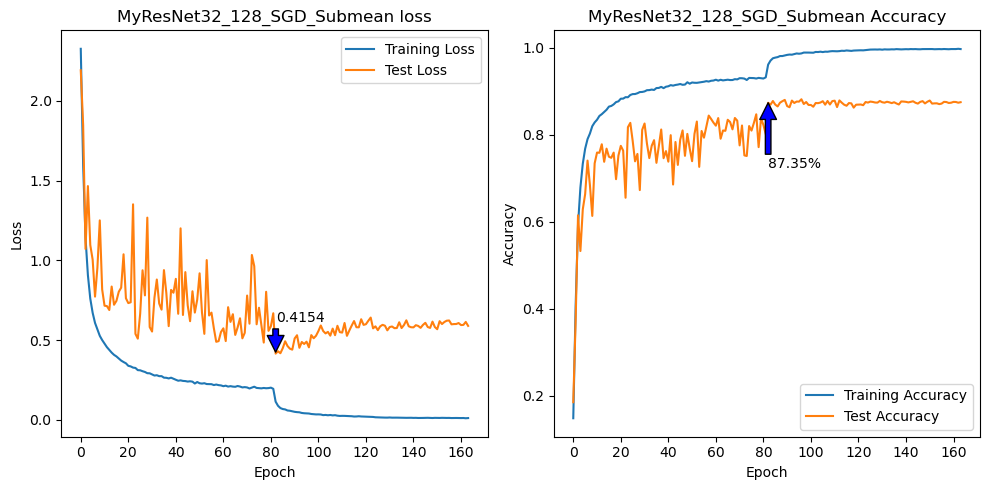

In [20]:
view = LogViewer(logs)
file_name = f"{file_name}_Submean"
view.draw(title=file_name, save=True, min_marker=True)

In [19]:
view.print_all()

1 epoch: train_loss=2.3262, train_acc=0.1481, test_loss=2.1915, test_acc=0.1850, lr=0.1000
2 epoch: train_loss=1.5980, train_acc=0.4070, test_loss=1.8476, test_acc=0.3728, lr=0.1000
3 epoch: train_loss=1.1405, train_acc=0.5927, test_loss=1.0715, test_acc=0.6147, lr=0.1000
4 epoch: train_loss=0.9072, train_acc=0.6785, test_loss=1.4656, test_acc=0.5326, lr=0.1000
5 epoch: train_loss=0.7602, train_acc=0.7331, test_loss=1.0961, test_acc=0.6282, lr=0.1000
6 epoch: train_loss=0.6710, train_acc=0.7679, test_loss=1.0044, test_acc=0.6635, lr=0.1000
7 epoch: train_loss=0.6078, train_acc=0.7898, test_loss=0.7726, test_acc=0.7405, lr=0.1000
8 epoch: train_loss=0.5666, train_acc=0.8027, test_loss=0.9547, test_acc=0.6844, lr=0.1000
9 epoch: train_loss=0.5269, train_acc=0.8196, test_loss=1.2506, test_acc=0.6133, lr=0.1000
10 epoch: train_loss=0.5004, train_acc=0.8283, test_loss=0.8177, test_acc=0.7343, lr=0.1000
11 epoch: train_loss=0.4776, train_acc=0.8345, test_loss=0.7156, test_acc=0.7590, lr=0.10